In [3]:
# Klasterizuojami ir vaizduojami ML anotuoti pūpsniai atskirai kiekvienoje iš grupių
# su ML anotacijomis N, S, V.
# Vaizdavimas atliekamas rodant užklotus po vieną pūpsnį.
# 
# Klasterizacija atliekama esant pakankamam N, S ar V grupės dydžiui. U grupė neklasterizuojama.
#  
# Skriptas EKG įrašo pūpsnių klasterizacijai panaudojant VU FDA požymius
# Šis variantas pritaikytas įrašams, kuriems rpeaks surandami su Neurokitu,
# o anotacijos yra gautos su ML.anotuotams įrašams. Yra ir kitas variantas
# (zive_clustering_of_annotated_records.ipynb), pritaikytas darbui su rpeaks
# ir anotacijomis, atsisiųtomis iš duomneų bazės.   

# Planas:
# Nuskaitome EKG įrašą
# Surandame su Neurokit2 R pikus
# Apskaičiuojame visiems pūpsniams požymius ir suformuojame požymių masyvą
# Surandame visiems R pikams ML anotacijas
# Atliekame klasterizaciją
# Atvaizduojame klasterius grafiškai

import tensorflow as tf
import pandas as pd
import numpy as np
# import matplotlib.pyplot as plt
import time
import sys, os, json
from pathlib import Path
import pickle
import sklearn
import neurokit2 as nk
from zive_clustering import get_sequences_min_max, show_beats, show_beats_in_same_plot
from sklearn.cluster import KMeans

# Į sys.path įtraukiamas aukščiau esantis aplankas, reikalingas modulių importavimui
# https://www.geeksforgeeks.org/get-parent-of-current-directory-using-python/ panaudojau šitą
path = os.getcwd() # Current Directory
parent = os.path.dirname(path) # parent directory
sys.path.insert(1, parent)

from zive_util_vu import runtime
from zive_util_vu import create_dir, get_rec_file_name, get_recId
from zive_util_vu import get_seq_start_end, read_rec, read_rec_attrib, split_SubjCode
from zive_cnn_fda_vu_v3_micro import read_RR_arr_from_signal, read_seq_from_signal
from zive_cnn_fda_vu_v3_micro import get_beat_features_set_fda_vu_v1_micro

my_os=sys.platform
print("OS in my system : ",my_os)

if my_os != 'linux':
    OS = 'Windows'
else:  
    OS = 'Ubuntu'


print('tf version:', tf.__version__)
print('sklearn version:', sklearn.__version__)

np.set_printoptions(threshold=sys.maxsize)
pd.set_option("display.max_rows", 6000)
pd.set_option("display.max_columns",200)
pd.set_option('display.width', 1000)

import warnings
warnings.filterwarnings("ignore")

# Naudojamų požymių sąrašas 
all_features = ['seq_size','RR_l_0', 'RR_r_0', 'RR_r/RR_l','wl_side','wr_side',
                'signal_mean', 'signal_std', 'P_val', 'Q_val', 'R_val', 'S_val', 'T_val',
                'P_pos', 'Q_pos', 'R_pos', 'S_pos', 'T_pos', 'QRS', 'PR', 'ST', 'QT', '0', '1', '2',
                '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18',
                '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32',
                '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46',
                '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60',
                '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74',
                '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88',
                '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102',
                '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114',
                '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126',
                '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138',
                '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150',
                '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162',
                '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174',
                '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186',
                '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198',
                '199']


def clustering(df_attr_features_ml_group_X, features, scaler, n_clusters):
    
    if (n_clusters > 1):
        # Paliekame tik užduotus požymius ir normalizuojame
        df_tmp = df_attr_features_ml_group_X[features]
        # print(data_frame_init.head())
        # Duomenis normalizuojame
        X = scaler.transform(df_tmp)

        # define the model
        model = KMeans(n_clusters, random_state=0)

        # fit the model
        model.fit(X)

        # assign a cluster to each example
        yhat = model.predict(X)
        # print(type(yhat), yhat.shape)

        # retrieve unique clusters
        clusters = np.unique(yhat)
        # print(clusters)
    else:
        yhat = np.zeros(len(df_attr_features_ml_group_X), int)

    # Paliekame masyvus tik su atributais, be požymių, požymių stulpelius panaikiname
    df_attr_ml_group_X = df_attr_features_ml_group_X.drop(features, axis=1, inplace=False)

    # Papildome atributus klasterių numeriais 
    df_attr_ml_group_X['cluster'] = list(yhat)
    # print("\nKlasteris be U: df_attr_be_U")
    return df_attr_ml_group_X


def get_clusters_n(len_group):
    """
    Nustato, į kiek klasterių dalinti pūpsnių grupę, priklausomai 
    nuo grupės dydžio len_group
    len_group: int, grupės dydis
    """
    clusters_n = 0
    if (len_group >= 500):
        clusters_n = 10
    elif len_group >= 100 and len_group <500:
        clusters_n = 5
    elif len_group >= 10 and len_group <100:
        clusters_n = 3
    return clusters_n

def show_beats_in_group(signal, df_attr_ml_group_X, group_symbol, w_side, min, max, fig_width, fig_height, max_graphs, print_rpeaks):
    
    # Sugrupuojame atributus pagal klasterius,
    # surandame klasterių indeksus mažėjančia klasterių dydžio tvarka 
    gr = df_attr_ml_group_X.groupby(['cluster'])
    sr_sizes = gr.size()
    sr_sizes = sr_sizes.sort_values(ascending=False)
    df_sizes = sr_sizes.to_frame(name='sizes').reset_index()

    # čia įdedame spausdinimo ciklą per klasterius, išvesdami klasterių statistiką
    print("\nML anotacija", group_symbol, ":" )
    for item, row in df_sizes.iterrows():
        cluster = row['cluster']
        df_gr = gr.get_group(cluster)
        atr_symbol_clust = np.array(list(df_gr['atr_symbol']))
        (unique, counts) = np.unique(atr_symbol_clust, return_counts=True)
        total = counts.sum()
        print(f'item: {item:>6}   cluster: {cluster:>6}   statistika: {unique} {counts} {total}')

        # Jei print_rpeaks == True, tai S, V ir U atvejais išvedame anotacijų rpeaks
        if (print_rpeaks and ((group_symbol == "S" or group_symbol == "V" or group_symbol == "U"))):
            # print(df_gr.head(6))
            dict_X = dict(zip(df_gr['idx'], df_gr['atr_sample']))
            print(group_symbol,': (idx, rpeak)', dict_X)

    # Ciklas per užduotus klasterius
    clusters_sorted = sr_sizes.index
    n_clusters = gr.ngroups

    # Ciklas per klasterius
    for item in range(n_clusters):
        cluster = clusters_sorted[item]
        df_gr = gr.get_group(cluster)
        print('\nitem:', item, 'cluster:', cluster, 'size:', len(df_gr))

        #  Statistika apie pūpsnius klasteryje
        atr_symbol_clust = np.array(list(df_gr['atr_symbol']))
        (unique, counts) = np.unique(atr_symbol_clust, return_counts=True)
        total = counts.sum()
        print("statistika klasteryje: ", unique, counts, total)

        if (len(df_gr) == 1):
            dict_attr = {'seq_nr':0, 'rpeak':df_gr['atr_sample'].values[0], 'symbol':df_gr['atr_symbol'].values[0]}
            print(dict_attr)        

        # Grafika
        min, max = get_sequences_min_max(signal, df_gr, w_side)
        show_beats_in_same_plot(signal, df_gr, w_side, min, max, fig_width, fig_height)
        
        if ((max_graphs != 0) and (len(df_gr) != 1)):
            show_beats(signal, df_gr, w_side, min, max, fig_width, fig_height, max_graphs= max_graphs)

    return



OS in my system :  linux
tf version: 2.6.0
sklearn version: 1.0.1


Skriptas bandymams klasterizuoti EKG įrašo pūpsnius su ML anotacijomis kiekvienai anotacijai atskirai
Naudojami VU FDA požymiai, scaler ir modelio parametrai nuskaitomi iš modelio CNN VU aplanko

Bendras duomenų aplankas:  /home/kesju/DI
Zive duomenų aplankas:  DUOM_2022_RUDUO_2
Aplankas su EKG įrašais (.npy) ir anotacijomis (.json)  /home/kesju/DI/DUOM_2022_RUDUO_2/records_npy
Diskretizavimo dažnis:  200
Klasifikavimo schema: {'N': 0, 'S': 1, 'V': 2}
Klasių skaičius: 3
Visos galimos anotacijos: ['N', 'S', 'V', 'U']
Scaler ir modelio parametrai nuskaitomi iš aplanko:  model_cnn_fda_vu_v1
Klasterizuojamas įrašas: 101940

SubjCode: 101940 userNr: 1019
file_name: 1631027.284 userId: 6144c682bd0cc5acb7275368 recId: 6145fd97bd0cc54b03275bba signal_length: 127999

Bendra N, S ir V statistika įraše:
statistika: ['N' 'V'] [690  47] 737
U skaičius: 4

Informacija apie klasterius:

ML anotacija N :
item:      0   cluster:      6   statistika: ['N'] [152] 152
item:      1   cluster:      8   stat

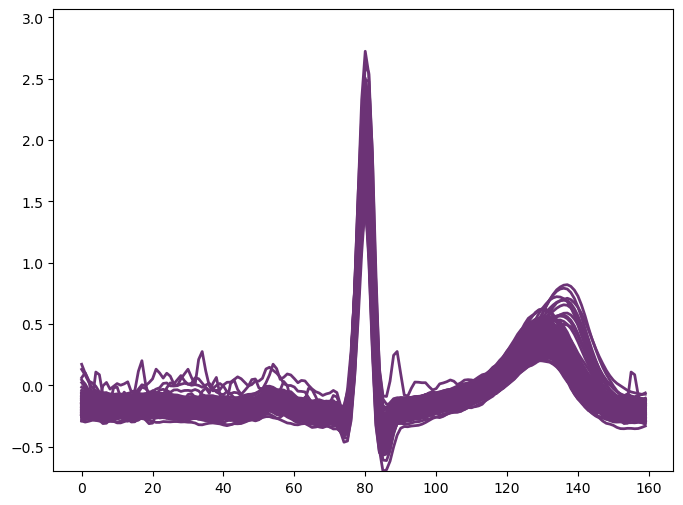


item: 1 cluster: 8 size: 132
statistika klasteryje:  ['N'] [132] 132


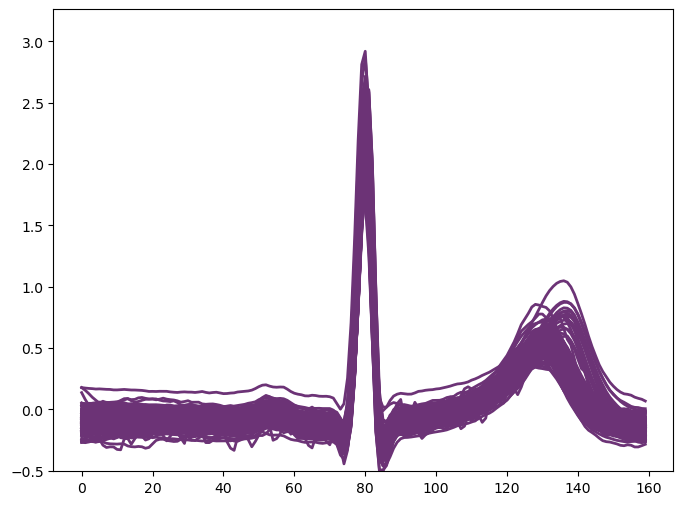


item: 2 cluster: 0 size: 125
statistika klasteryje:  ['N'] [125] 125


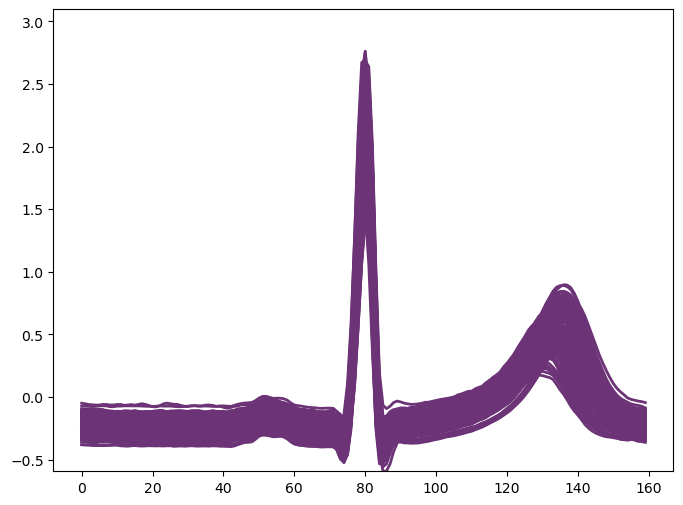


item: 3 cluster: 1 size: 97
statistika klasteryje:  ['N'] [97] 97


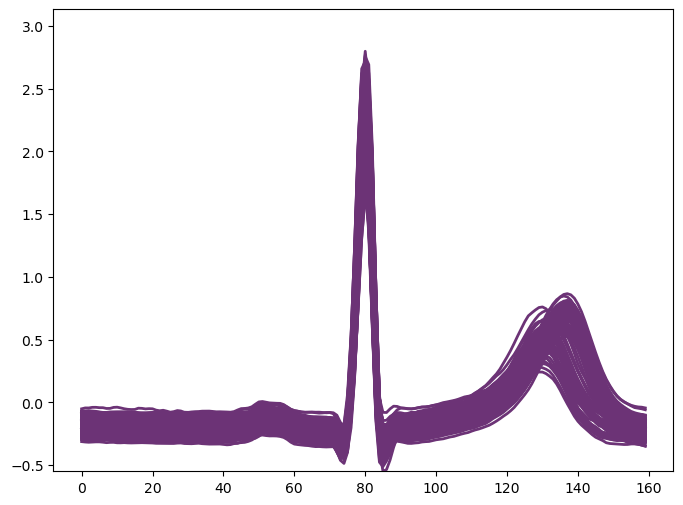


item: 4 cluster: 3 size: 87
statistika klasteryje:  ['N'] [87] 87


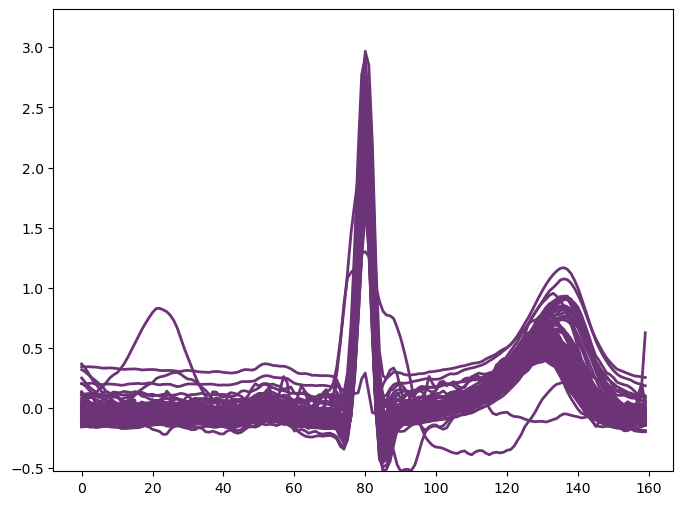


item: 5 cluster: 9 size: 40
statistika klasteryje:  ['N'] [40] 40


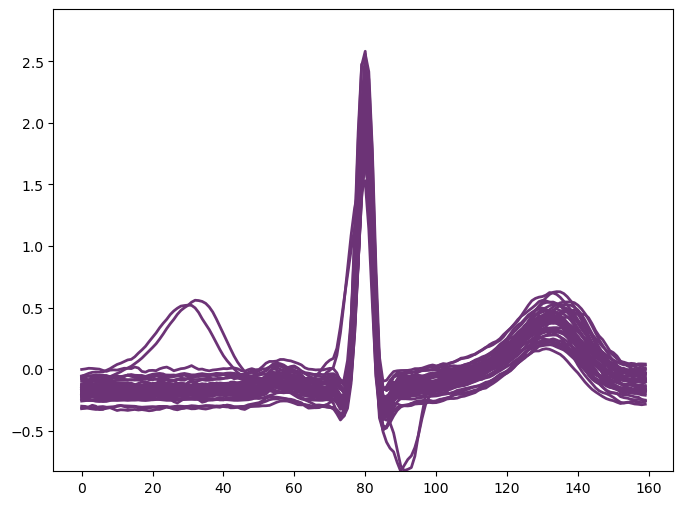


item: 6 cluster: 7 size: 19
statistika klasteryje:  ['N'] [19] 19


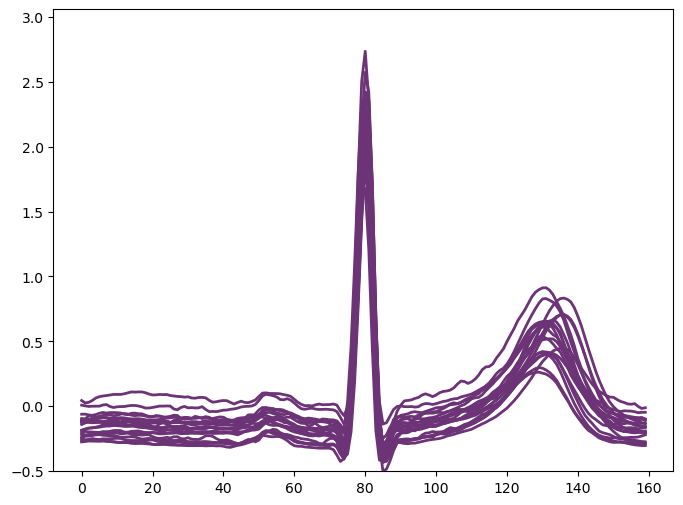


item: 7 cluster: 5 size: 18
statistika klasteryje:  ['N'] [18] 18


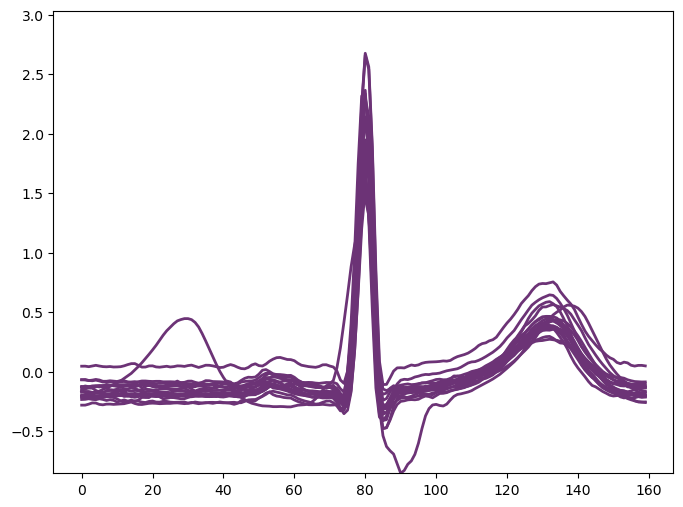


item: 8 cluster: 2 size: 15
statistika klasteryje:  ['N'] [15] 15


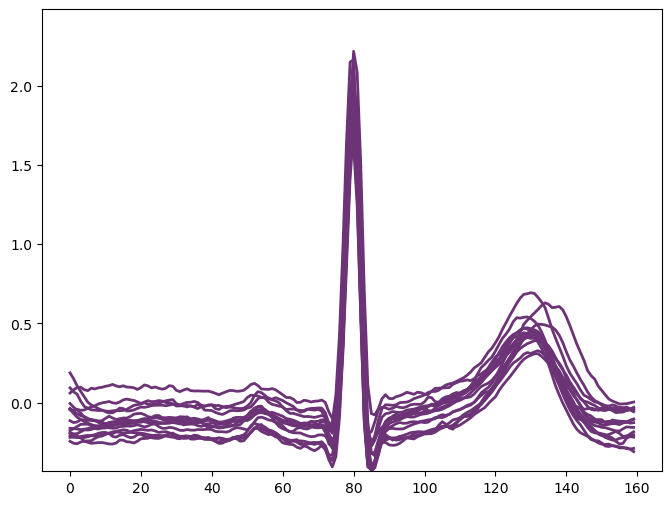


item: 9 cluster: 4 size: 5
statistika klasteryje:  ['N'] [5] 5


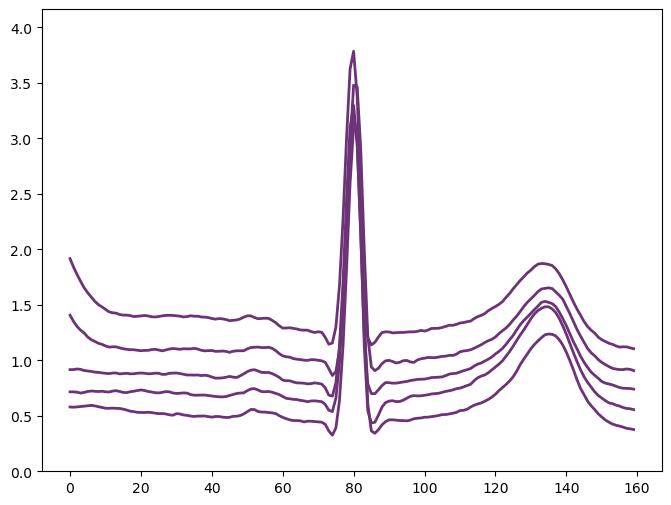


ML anotacija V :
item:      0   cluster:      0   statistika: ['V'] [19] 19
item:      1   cluster:      2   statistika: ['V'] [17] 17
item:      2   cluster:      1   statistika: ['V'] [11] 11

item: 0 cluster: 0 size: 19
statistika klasteryje:  ['V'] [19] 19


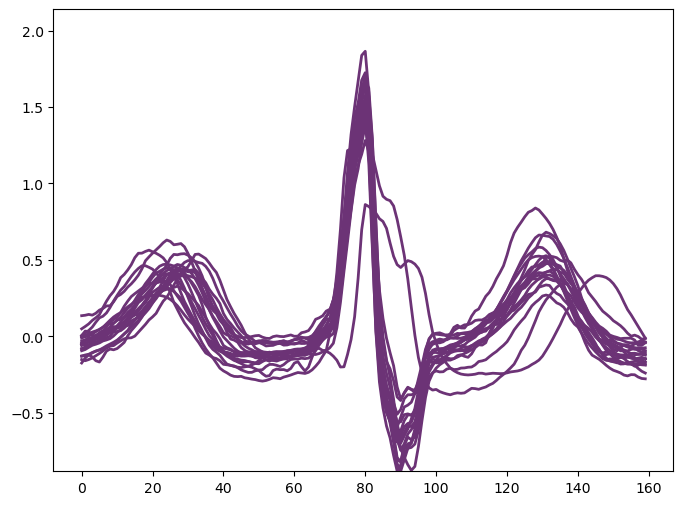


item: 1 cluster: 2 size: 17
statistika klasteryje:  ['V'] [17] 17


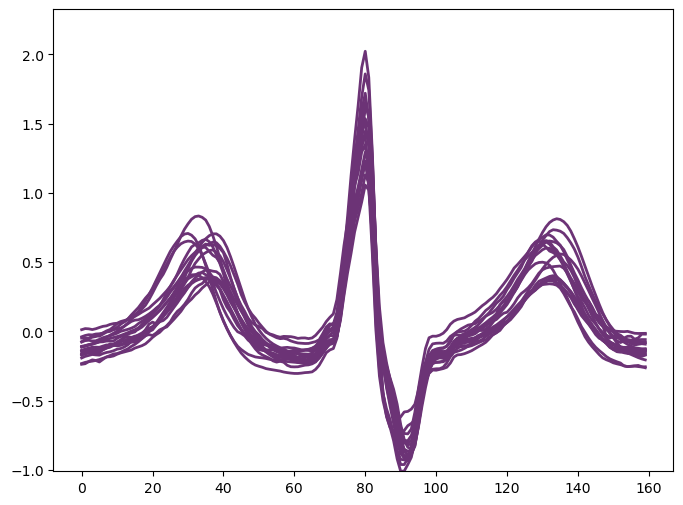


item: 2 cluster: 1 size: 11
statistika klasteryje:  ['V'] [11] 11


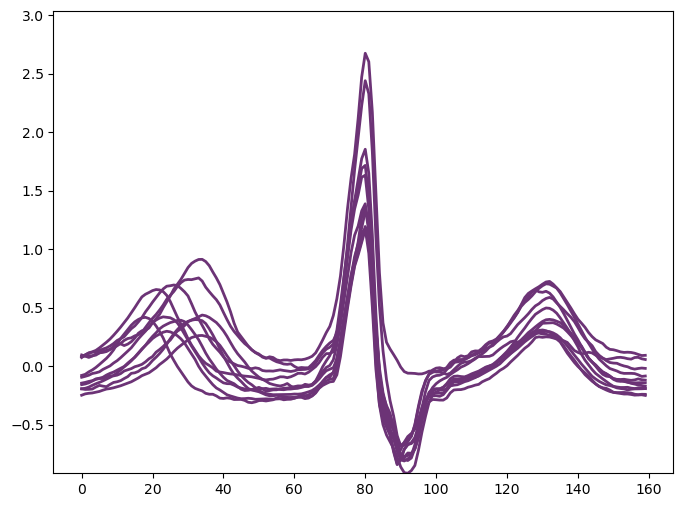


ML anotacija U :
item:      0   cluster:     99   statistika: ['U'] [4] 4

item: 0 cluster: 99 size: 4
statistika klasteryje:  ['U'] [4] 4


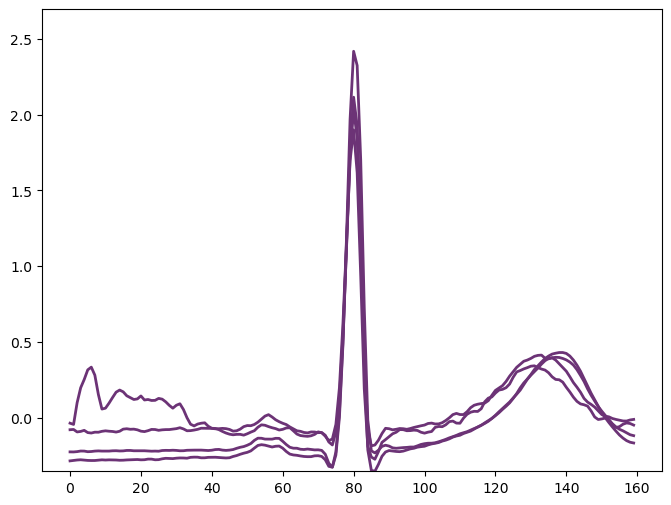

Runtime: 00:00:31


In [4]:
# Pagrindinis skriptas

print("Skriptas bandymams klasterizuoti EKG įrašo pūpsnius su ML anotacijomis kiekvienai anotacijai atskirai")
print('Naudojami VU FDA požymiai, scaler ir modelio parametrai nuskaitomi iš modelio CNN VU aplanko')


# //////////////// NURODOMI DUOMENŲ PARAMETRAI /////////////////////////////////////////////////////

# Bendras duomenų aplankas, kuriame patalpintas subfolderis name_db

if OS == 'Windows':
    Duomenu_aplankas = 'D:\\DI'   # variantas: Windows
    # Duomenu_aplankas = 'F:\DI\Data\MIT&ZIVE\VU'   # variantas: Herkulis
else:
    Duomenu_aplankas = '/home/kesju/DI'   # arba variantas: UBUNTU, be Docker

# jei variantas Docker pasirenkame:
# Duomenu_aplankas = '/Data/MIT&ZIVE'

# Vietinės talpyklos aplankas ir pūpsnių atributų failas
db_folder = 'DUOM_2022_RUDUO_2'

# Failai pūpsnių klasių formavimui
selected_beats = {'N':0, 'S':1, 'V':2}
all_beats =  {'N':0, 'S':1, 'V':2, 'U':3}  

# Diskretizavimo dažnis:
fs = 200

#  Nuoroda į aplanką su duomenų rinkiniu
db_path = Path(Duomenu_aplankas, db_folder)

# Nuoroda į aplanką su EKG įrašais (.npy) ir anotacijomis (.json)
rec_dir = Path(db_path, 'records_npy')

# Nuoroda į modelio aplanką
# model_dir = Path(Duomenu_aplankas, 'DNN', 'best_models', 'all_ft')
model_dir = 'model_cnn_fda_vu_v1'

# Išvedame parametrus
print("\nBendras duomenų aplankas: ", Duomenu_aplankas)
print("Zive duomenų aplankas: ", db_folder)
print("Aplankas su EKG įrašais (.npy) ir anotacijomis (.json) ", rec_dir)
print("Diskretizavimo dažnis: ", fs)
print('Klasifikavimo schema:', selected_beats)
print('Klasių skaičius:', len(selected_beats))
print('Visos galimos anotacijos:', list(all_beats.keys()))
print("Scaler ir modelio parametrai nuskaitomi iš aplanko: ", model_dir)
# print("\n")


# mark1

# NURODOME PACIENTŲ SĄRAŠĄ. GALIMI ĮVAIRŪS VARIANTAI

SubjCode = 10030 # quality = 0, labai stabilus įrašas, be triukšmų
# Column1	userNr	recordingNr	recId	                    file_name	N	S	V	U	Nml	Sml	Vml	Uml	Nprec	Nrec	Nfsc	Sprec	Srec	Sfsc	Vprec	Vrec	Vfsc	Err%	nesutmp	quality	
# 16	    1003	0	        613f57ea3d08d45609cdcc86	1630726.223	603	0	1	0	602	0	0	2	1,00	1,00	1,00	0,00	0,00	0,00	0,00	0,00	0,00	0,20	0	    0	    labai stabilus įrašas, be triukšmų, 3 min.

# SubjCode = 10130 # quality = 0, izolinija vaikšto nedaug, labai nedaug vietomis išlenda raumenų triušmai, 381 V, bet atpažino 326
# 107	    1013	0	        6144cd8bbd0cc52fe9275398	1631080.771	509	0	381	0	551	8	326	5	0,92	0,99	0,95	0,00	0,00	0,00	1,00	0,86	0,93	6,10	0	    0	izolinija vaikšto nedaug, labai nedaug vietomis išlenda raumenų triušmai, 381 V, bet atpažino 326, 8 min.

# SubjCode = 101322 # quality = 1, Yra intervalų su paplaukiančia izolinija, taip pat yra intervalų su padidėjusiu raumenų triukšmu, bei kontaktinio triūkšmo. Daug V, nemažai akivaizdžių (apie 20%) neatpažinta
# 129	    1013	22	        6144cd8bbd0cc52ca32753a4	1631032.393	862	0	49	0	849	6	39	17	0,98	0,99	0,98	0,00	0,00	0,00	0,87	0,69	0,77	2,90	0	1	Naudota cluster testavimui.  Yra intervalų su paplaukiančia izolinija, taip pat yra intervalų su padidėjusiu raumenų triukšmu, bei kontaktinio triūkšmo. Daug V, nemažai akivaizdžių (apie 20%) neatpažinta

# SubjCode = 10140 # quality = 2, Vietomis daug triukšmų, panašu į kontaktinius
# 148	1014	0	6145ae5ebd0cc5e15f2756e4	1630947.302	816	0	0	0	738	0	9	69	1,00	0,99	0,99	0,00	0,00	0,00	0,00	0,00	0,00	1,20	0	2	Vietomis daug triukšmų, panašu į kontaktinius

SubjCode = 101940 # quality = 0
# 266	1019	40	6145fd97bd0cc54b03275bba	1631027.284	691	0	51	0	690	0	47	5

# ////////////////////////////  PARAMETRAI VAIZDAVIMUI  ////////////////////////////////////////////////////

# Maksimalus grafikų skaičius, išvedant kiekvieną grafiką klasteryje atskirai 
max_graphs = 0

# EKG pūpsnio reikšmių lango į vieną pusę plotis
w_side = 80

# Lango, kuriame vaizduojami grafikai, plotis ir aukštis
fig_width, fig_height = 8, 6

# Užduodame, ar rodyti klasterį su U
U_flag = True  #  True - rodyti

# Užduodame, ar išvesti S, V, U anotacijoms rpeaks
print_rpeaks = False  # True - rodyti


# //////////////// PASIRUOŠIMAS ////////////////////////////////////////////////////////////////////

# Klasių simbolinių vardų sąrašas ir klasių skaičius
class_names = list(selected_beats.keys()) 
n_classes = len(selected_beats)
# print(class_names)

# nuskaitome modelio parametrus
model_path = Path(parent, model_dir, 'best_model_final_2.h5')
model = tf.keras.models.load_model(model_path)

 # Nuskaitome scaler objectą
path_scaler = Path(parent, model_dir, 'scaler.pkl')  
scaler = pickle.load(open(path_scaler,'rb'))


# //////////////// NUSKAITOMAS ĮRAŠAS /////////////////////////////////////////////////////

print("Klasterizuojamas įrašas:", SubjCode)

start_time = time.time()

# Nuskaitome EKG įrašą (npy formatu)
file_path = Path(rec_dir, str(SubjCode) + '.npy')
sign_raw = np.load(file_path)
# sign_raw = read_rec(rec_dir, SubjCode)
signal_length = sign_raw.shape[0]
signal = sign_raw

# Surandame ir išvedame įrašo atributus
userNr, recNr = split_SubjCode(SubjCode)
userId, recId, file_name = get_recId(rec_dir, userNr, recNr)
# print(f"\nSubjCode: {SubjCode} userNr: {userNr:>2} file_name: {file_name:>2} userId: {userId} recId: {recId} signal_length: {signal_length}")


# //////// NUSTATOME rpeaak VIETAS, APSKAIČIUOJAME PŪPSNIŲ POŽYMIUS IR SURANDAME ML ANOTACIJAS //////////

# Nustatome R pikų vietas
_, rpeaks = nk.ecg_peaks(signal, sampling_rate=200, correct_artifacts=False)
atr_sample = rpeaks['ECG_R_Peaks']
# print(type(atr_sample))
# print("Neurokit:",atr_sample[:50])


idx_lst = list(range(1, len(atr_sample)-1))  # pastaba: idx_lst sąrašas nuo 1 iki atr_sample-2

# Formuojame iš pūpsnių požymių masyvą: data_frame yra tik tos eilutės,
# kurių indeksai nepapuolė į omitted (atitinka automatines anotacijas 'U')
df_attr_features_be_U, omitted = get_beat_features_set_fda_vu_v1_micro(signal, atr_sample, idx_lst)

data_frame = df_attr_features_be_U.set_index('idx')
df_attr_features_be_U.columns = df_attr_features_be_U.columns.astype(str)

# paruošiame požymių masyvą klasifikatoriui
test_x = df_attr_features_be_U[all_features]
x_test = scaler.transform(test_x)
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
# print("len(test_x):", len(test_x))

# Pūpsnių klasių atpažinimas (ML anotacijos)
predictions = model.predict(x_test)
atr_labels_be_U = np.argmax(predictions, axis=1)


# //////////////// PARUOŠIAME DUOMENŲ MASYVUS KLASTERIZACIJAI  //////////////////////////////////

# Parengiame R pikų ir ML anotacijų masyvus taip, kad juose nebūtų elementų iš omitted,
# taip pat atmetame reikšmes su indeksu 1 ir len(atr_sample)-1)

# Atmetame reikšmes su indeksu 1 ir len(atr_sample)-1)
atr_sample = atr_sample[idx_lst]
# print("atmetus 1 ir paskutini:",len(atr_sample))
# print("atmetus 1 ir paskutini:", atr_sample[:50])

# Suformuojame atr_sample_be_U
idxs_su_U = []
if (not omitted.empty):
    idxs_su_U = list(omitted['idx'])
    # print("idxs_su_U:",idxs_su_U)
    atr_sample_be_U = np.asarray([atr_sample[item] for item in range(len(atr_sample)) if (item not in idxs_su_U)])
# print("atmetus su 'U':",len(atr_sample_be_U))
# print("atr_sample_be_U:", atr_sample_be_U[:50])

# Suformuojame atr_symbol_be_U panaudodami atpažintus atr_labels_be_U
invers_all_beats = {v: k for k, v in all_beats.items()}
atr_symbol_be_U = np.array([invers_all_beats[sample] for sample in atr_labels_be_U])
# print("atr_symbol_be_U:",atr_symbol_be_U[:50])

# Pūpsnių statistika
(unique, counts) = np.unique(atr_symbol_be_U, return_counts=True)
total = counts.sum()
# print("class labels: ", unique, counts, total)

# Pridedame atributus atr_sample_be_U, atr_symbol_be_U prie požymių datafreimo,
# skirto klasterizacijai
df_attr_features_be_U['atr_sample'] = atr_sample_be_U
df_attr_features_be_U['atr_symbol'] = atr_symbol_be_U
# print("\nMasyvas be U: df_attr_features_be_U len:", len(df_attr_features_be_U) )
# print(df_attr_features_be_U.columns)

# # Suformuojame masyvą su `U` df_attr_su_U, kuris bus naudojamas kaip atskiras klasteris
# # df_attr_su_U = pd.DataFrame(columns=['atr_sample', 'atr_symbol',  'cluster'])
df_attr_su_U = pd.DataFrame()
if (idxs_su_U):
    attr_su_U = []
    for item in idxs_su_U:
        dict_tmp = {
            'idx': item,
            'atr_sample': atr_sample[item],
            'atr_symbol': 'U',
            'cluster': 99
        }
        attr_su_U.append(dict_tmp)
    df_attr_su_U = pd.DataFrame(attr_su_U)
# print("\nKlasteris su U: df_attr_su_U len:", len(df_attr_su_U) )
# print(df_attr_su_U.head())

# end_time = time.time()
# print('\npožymiai:')
# runtime(end_time-start_time)


# /////////////////  ML anotacijų N, S, V grupių klasterizacija. Anotacijos U neklasterizuojamos

# Išvedame įrašo atributus
userId, recId, file_name = get_recId(rec_dir, userNr, recNr)
print(f"\nSubjCode: {SubjCode} userNr: {userNr:>2}")
print(f"file_name: {file_name:>2} userId: {userId} recId: {recId} signal_length: {signal_length}")

# Bendra įrašo anotacijų (atmetus U) statistika
atr_symbol_group = np.array(list(df_attr_features_be_U['atr_symbol']))
(unique, counts) = np.unique(atr_symbol_group, return_counts=True)
total = counts.sum()
print("\nBendra N, S ir V statistika įraše:")
print(f'statistika: {unique} {counts} {total}')
print("U skaičius:", len(df_attr_su_U))

# Sugrupuojame atributus pagal ML grupes
ml_groups = df_attr_features_be_U.groupby(['atr_symbol'])

# Klasterizuojame ML grupes  N, S, V kiekvieną atskirai

# N grupės klasterizacija
print("\nInformacija apie klasterius:")

if 'N' in ml_groups.groups.keys():
    df_attr_features_ml_group_N = ml_groups.get_group('N')
    n_clusters_N = get_clusters_n(len(df_attr_features_ml_group_N))
    df_attr_ml_group_N = clustering(df_attr_features_ml_group_N, all_features, scaler, n_clusters_N)
    show_beats_in_group(signal, df_attr_ml_group_N, 'N', w_side, min, max, fig_width, fig_height, max_graphs, False)


# S grupės klasterizacija
if 'S' in ml_groups.groups.keys():
    df_attr_features_ml_group_S = ml_groups.get_group('S')
    n_clusters_S = get_clusters_n(len(df_attr_features_ml_group_S))
    df_attr_ml_group_S = clustering(df_attr_features_ml_group_S, all_features, scaler, n_clusters_S)
    show_beats_in_group(signal, df_attr_ml_group_S, 'S', w_side, min, max, fig_width, fig_height, max_graphs, print_rpeaks)


# V grupės klasterizacija
if 'V' in ml_groups.groups.keys():
    df_attr_features_ml_group_V = ml_groups.get_group('V')
    n_clusters_V = get_clusters_n(len(df_attr_features_ml_group_V))
    df_attr_ml_group_V = clustering(df_attr_features_ml_group_V, all_features, scaler, n_clusters_V)
    show_beats_in_group(signal, df_attr_ml_group_V, 'V', w_side, min, max, fig_width, fig_height, max_graphs, print_rpeaks)

# Rodome klasterių grafikus grupei U
if (not df_attr_su_U.empty and U_flag):
    show_beats_in_group(signal, df_attr_su_U, 'U', w_side, min, max, fig_width, fig_height, max_graphs, print_rpeaks)    


end_time = time.time()
runtime(end_time-start_time)

# mark2